In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta

plt.style.use("default")
plt.rcParams["figure.figsize"] = (10, 5)

In [2]:
users = pd.read_csv("../data/users.csv", parse_dates=["signup_date"])
orders = pd.read_csv("../data/orders.csv", parse_dates=["order_date"])
reviews = pd.read_csv("../data/reviews.csv", parse_dates=["review_date"])
events = pd.read_csv("../data/events.csv", parse_dates=["event_timestamp"])

In [3]:
for name, df in {
    "users": users,
    "orders": orders,
    "reviews": reviews,
    "events": events
}.items():
    print(name, df.shape)

users (10000, 6)
orders (20000, 5)
reviews (15000, 7)
events (80000, 5)


In [4]:
as_of_date = max(
    events["event_timestamp"].max(),
    orders["order_date"].max(),
    reviews["review_date"].max()
)

as_of_date

Timestamp('2025-11-14 23:36:10.745951')

In [5]:
last_event = (
    events
    .groupby("user_id")["event_timestamp"]
    .max()
    .reset_index(name="last_event_date")
)

last_order = (
    orders[orders["order_status"] == "Completed"]
    .groupby("user_id")["order_date"]
    .max()
    .reset_index(name="last_order_date")
)

activity = (
    users[["user_id"]]
    .merge(last_event, on="user_id", how="left")
    .merge(last_order, on="user_id", how="left")
)

activity["last_activity_date"] = activity[
    ["last_event_date", "last_order_date"]
].max(axis=1)

activity.head()

,user_id,last_event_date,last_order_date,last_activity_date
0,U000001,2025-09-22 09:02:17.315929,NaT,2025-09-22 09:02:17.315929088
1,U000002,2025-10-16 03:03:32.811708,NaT,2025-10-16 03:03:32.811707904
2,U000003,2025-02-23 05:10:10.468814,NaT,2025-02-23 05:10:10.468814080
3,U000004,2025-11-03 03:30:05.957955,NaT,2025-11-03 03:30:05.957955072
4,U000005,2025-07-13 11:45:55.390913,NaT,2025-07-13 11:45:55.390913024


In [6]:
CHURN_DAYS = 60

activity["days_since_last_activity"] = (
    as_of_date - activity["last_activity_date"]
).dt.days

activity["is_churned"] = (
    activity["days_since_last_activity"] >= CHURN_DAYS
).astype(int)

activity["is_churned"].value_counts(normalize=True)

is_churned
0    0.5151
1    0.4849
Name: proportion, dtype: float64

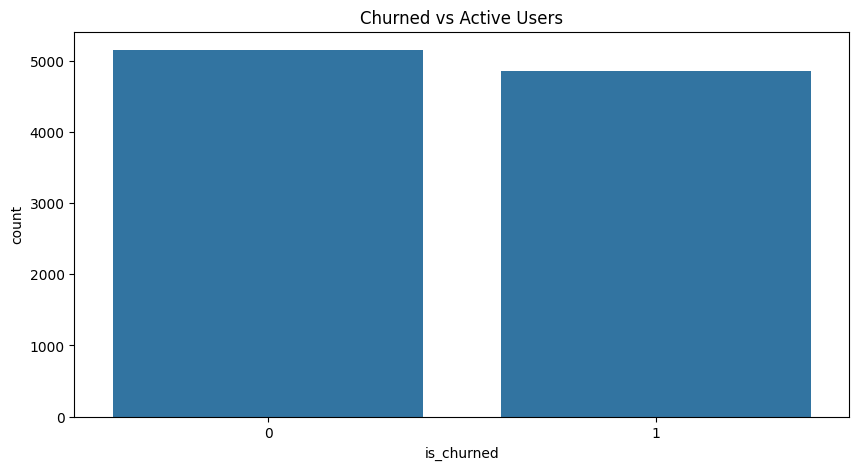

In [7]:
sns.countplot(
    x="is_churned",
    data=activity
)
plt.title("Churned vs Active Users")
plt.show()

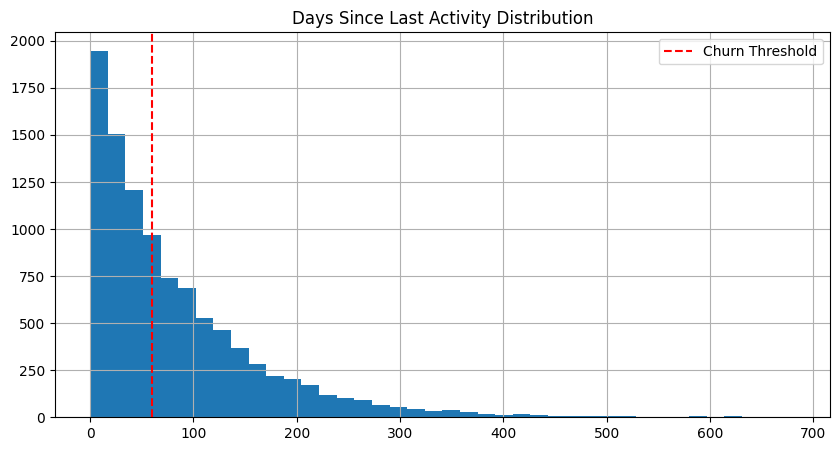

In [8]:
activity["days_since_last_activity"].hist(bins=40)
plt.axvline(60, color="red", linestyle="--", label="Churn Threshold")
plt.legend()
plt.title("Days Since Last Activity Distribution")
plt.show()

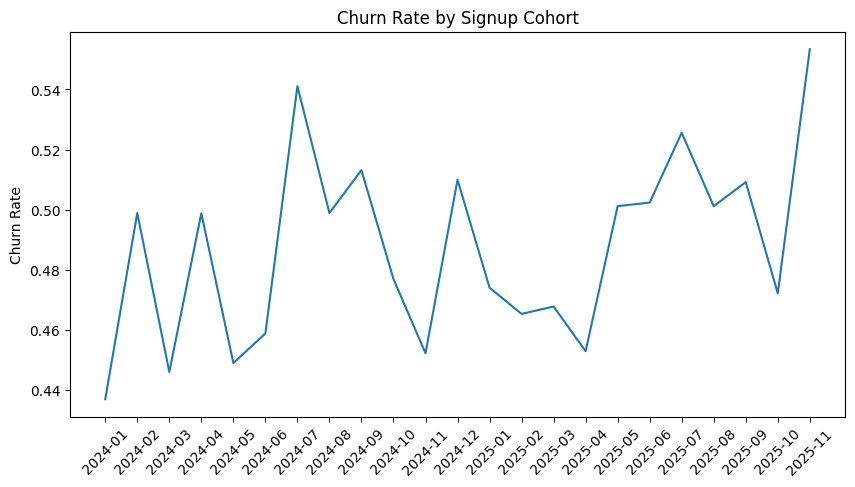

In [9]:
users["signup_month"] = users["signup_date"].dt.to_period("M")

cohort = (
    users[["user_id", "signup_month"]]
    .merge(activity[["user_id", "is_churned"]], on="user_id")
)

cohort_churn = (
    cohort
    .groupby("signup_month")["is_churned"]
    .mean()
    .reset_index()
)

plt.plot(
    cohort_churn["signup_month"].astype(str),
    cohort_churn["is_churned"]
)
plt.xticks(rotation=45)
plt.title("Churn Rate by Signup Cohort")
plt.ylabel("Churn Rate")
plt.show()

In [10]:
events_30d = events[
    events["event_timestamp"] >= as_of_date - timedelta(days=30)
]

engagement = (
    events_30d
    .groupby("user_id")
    .size()
    .reset_index(name="events_last_30d")
)

engagement = activity.merge(
    engagement, on="user_id", how="left"
).fillna(0)

C:\Users\shrey\AppData\Local\Temp\ipykernel_13956\2883603063.py:14: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0)


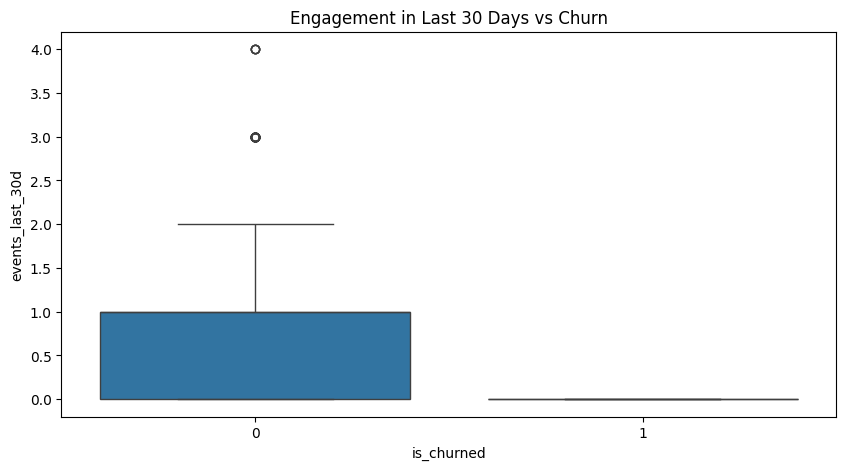

In [11]:
sns.boxplot(
    x="is_churned",
    y="events_last_30d",
    data=engagement
)
plt.title("Engagement in Last 30 Days vs Churn")
plt.show()

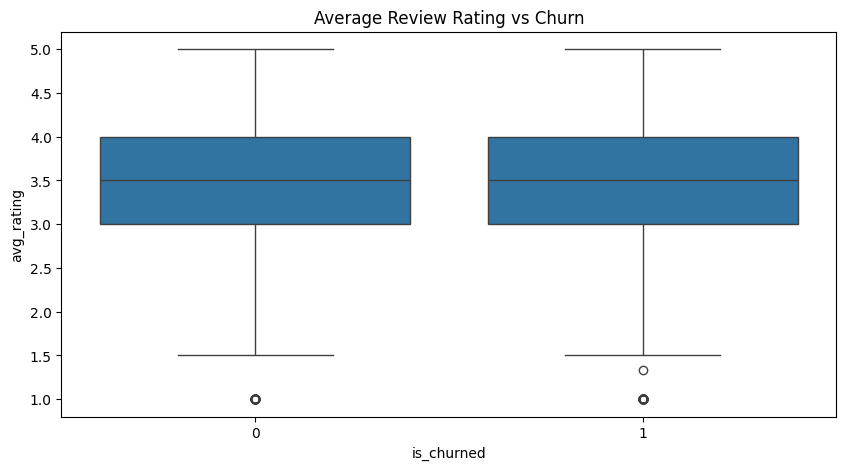

In [12]:
ratings = (
    reviews
    .groupby("user_id")["rating"]
    .mean()
    .reset_index(name="avg_rating")
)

ratings = activity.merge(ratings, on="user_id", how="left")

sns.boxplot(
    x="is_churned",
    y="avg_rating",
    data=ratings
)
plt.title("Average Review Rating vs Churn")
plt.show()

Churn is gradual, not binary

Engagement decay precedes churn

Ratings matter less than inactivity

30–59 day window is intervention zone

In [13]:
# -----------------------------
# Feature engineering for ML
# -----------------------------

features = activity[["user_id", "days_since_last_activity", "is_churned"]].copy()

# Engagement features
features = features.merge(
    engagement[["user_id", "events_last_30d"]],
    on="user_id",
    how="left"
)

# Order behavior
orders_agg = (
    orders[orders["order_status"] == "Completed"]
    .groupby("user_id")
    .agg(
        total_orders=("order_id", "count"),
        total_spend=("total_amount", "sum"),
        avg_order_value=("total_amount", "mean"),
    )
    .reset_index()
)

features = features.merge(orders_agg, on="user_id", how="left")

# Review signal
features = features.merge(
    ratings[["user_id", "avg_rating"]],
    on="user_id",
    how="left"
)

# Fill missing values (important!)
features.fillna(
    {
        "events_last_30d": 0,
        "total_orders": 0,
        "total_spend": 0,
        "avg_order_value": 0,
        "avg_rating": features["avg_rating"].mean(),
    },
    inplace=True,
)

features.head()

,user_id,days_since_last_activity,is_churned,events_last_30d,total_orders,total_spend,avg_order_value,avg_rating
0,U000001,53.0,0,0.0,0.0,0.0,0.0,3.333333
1,U000002,29.0,0,1.0,0.0,0.0,0.0,4.000000
2,U000003,264.0,1,0.0,0.0,0.0,0.0,4.500000
3,U000004,11.0,0,1.0,0.0,0.0,0.0,3.142857
4,U000005,124.0,1,0.0,0.0,0.0,0.0,4.000000


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, classification_report

In [15]:
X = features[
    [
        "events_last_30d",
        "total_orders",
        "total_spend",
        "avg_order_value",
        "avg_rating",
    ]
]

y = features["is_churned"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])

pipe.fit(X_train, y_train)

y_pred_proba = pipe.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
roc_auc

0.7937979162823114

In [16]:
import shap

imputer = pipe.named_steps["imputer"]
scaler = pipe.named_steps["scaler"]
model = pipe.named_steps["model"]

X_imputed = imputer.transform(X)
X_scaled = scaler.transform(X_imputed)

explainer = shap.LinearExplainer(model, X_scaled)
shap_values = explainer.shap_values(X_scaled)

In [17]:
print(classification_report(
    y_test,
    (y_pred_proba > 0.5).astype(int)
))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75      1288
           1       0.70      1.00      0.82      1212

    accuracy                           0.79      2500
   macro avg       0.85      0.80      0.79      2500
weighted avg       0.86      0.79      0.79      2500



In [18]:
import shap

# Extract trained model
log_reg = pipe.named_steps["model"]
scaler = pipe.named_steps["scaler"]

# Scale full feature set
X_scaled = pd.DataFrame(
    scaler.transform(X),
    columns=X.columns,
    index=X.index
)

explainer = shap.LinearExplainer(log_reg, X_scaled)
shap_values = explainer.shap_values(X_scaled)

c:\Projects\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


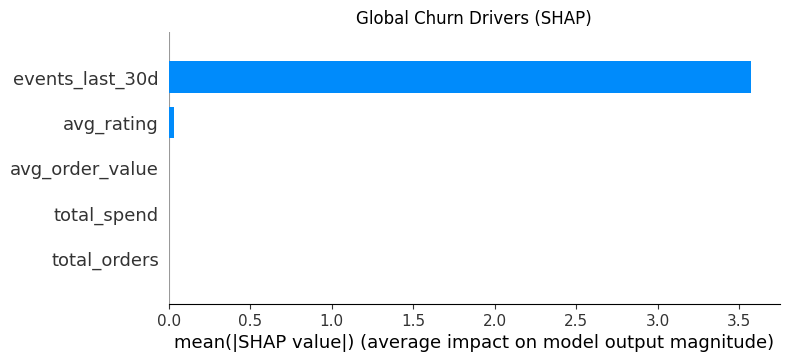

In [19]:
shap.summary_plot(
    shap_values,
    X,
    plot_type="bar",
    show=False
)
plt.title("Global Churn Drivers (SHAP)")
plt.show()

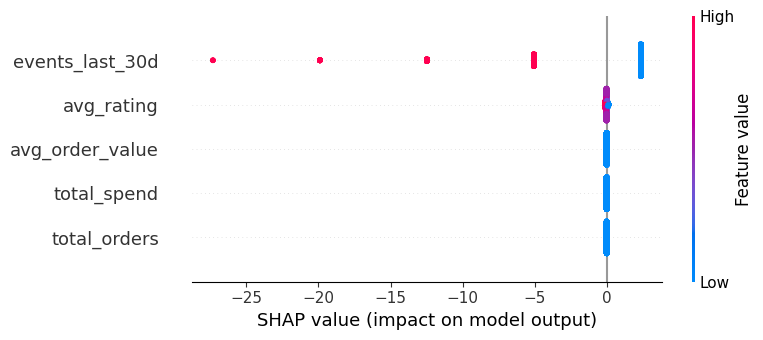

In [20]:
shap.summary_plot(
    shap_values,
    X,
    show=False
)
plt.show()

In [21]:
features["churn_probability"] = pipe.predict_proba(X)[:, 1]

In [22]:
def risk_bucket(p):
    if p < 0.3:
        return "Low"
    elif p < 0.6:
        return "Medium"
    else:
        return "High"

features["risk_bucket"] = features["churn_probability"].apply(risk_bucket)

In [23]:
features["risk_bucket"].value_counts(normalize=True)

risk_bucket
High    0.6946
Low     0.3054
Name: proportion, dtype: float64

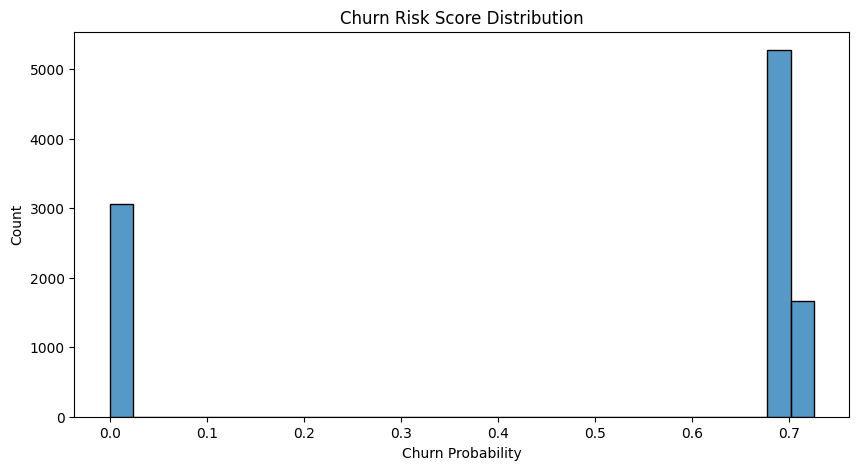

In [24]:
import seaborn as sns

sns.histplot(features["churn_probability"], bins=30)
plt.title("Churn Risk Score Distribution")
plt.xlabel("Churn Probability")
plt.show()

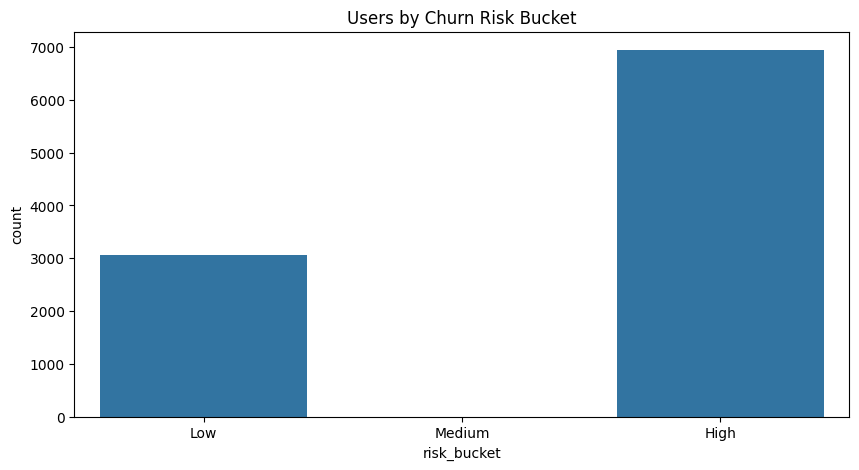

In [25]:
sns.countplot(
    x="risk_bucket",
    data=features,
    order=["Low", "Medium", "High"]
)
plt.title("Users by Churn Risk Bucket")
plt.show()

In [26]:
dashboard_df = (
    features
    .merge(activity[["user_id", "days_since_last_activity"]], on="user_id")
    .sort_values("churn_probability", ascending=False)
)

dashboard_df.head()

,user_id,days_since_last_activity_x,is_churned,events_last_30d,total_orders,total_spend,avg_order_value,avg_rating,churn_probability,risk_bucket,days_since_last_activity_y
4992,U004993,57.0,0,0.0,0.0,0.0,0.0,1.0,0.725787,High,57.0
2365,U002366,65.0,1,0.0,0.0,0.0,0.0,1.0,0.725787,High,65.0
9704,U009705,91.0,1,0.0,0.0,0.0,0.0,1.0,0.725787,High,91.0
1255,U001256,222.0,1,0.0,0.0,0.0,0.0,1.0,0.725787,High,222.0
8351,U008352,99.0,1,0.0,0.0,0.0,0.0,1.0,0.725787,High,99.0


In [27]:
print(dashboard_df.columns.tolist())

['user_id', 'days_since_last_activity_x', 'is_churned', 'events_last_30d', 'total_orders', 'total_spend', 'avg_order_value', 'avg_rating', 'churn_probability', 'risk_bucket', 'days_since_last_activity_y']


In [28]:
# -----------------------------
# FIX DUPLICATE COLUMN NAMES
# -----------------------------

if "days_since_last_activity_x" in dashboard_df.columns:
    dashboard_df = dashboard_df.drop(columns=["days_since_last_activity_x"])

if "days_since_last_activity_y" in dashboard_df.columns:
    dashboard_df = dashboard_df.rename(
        columns={"days_since_last_activity_y": "days_since_last_activity"}
    )

dashboard_df.head()

,user_id,is_churned,events_last_30d,total_orders,total_spend,avg_order_value,avg_rating,churn_probability,risk_bucket,days_since_last_activity
4992,U004993,0,0.0,0.0,0.0,0.0,1.0,0.725787,High,57.0
2365,U002366,1,0.0,0.0,0.0,0.0,1.0,0.725787,High,65.0
9704,U009705,1,0.0,0.0,0.0,0.0,1.0,0.725787,High,91.0
1255,U001256,1,0.0,0.0,0.0,0.0,1.0,0.725787,High,222.0
8351,U008352,1,0.0,0.0,0.0,0.0,1.0,0.725787,High,99.0


In [31]:
# -------------------------------------------------
# FIX: Convert Period to string for Dash / Plotly
# -------------------------------------------------

if "signup_month" in cohort_churn.columns:
    cohort_churn["signup_month"] = cohort_churn["signup_month"].astype(str)

In [43]:
# ======================================================
# CUSTOMER CHURN — EXECUTIVE DASHBOARD (LIGHT THEME)
# ======================================================

from dash import Dash, dcc, html, dash_table
import plotly.express as px
import plotly.graph_objects as go

# -----------------------------
# KPI CALCULATIONS
# -----------------------------
total_users = len(activity)
churned_users = int(activity["is_churned"].sum())
active_users = total_users - churned_users
churn_rate = churned_users / total_users

high_risk_users = (features["risk_bucket"] == "High").sum()
medium_risk_users = (features["risk_bucket"] == "Medium").sum()
low_risk_users = (features["risk_bucket"] == "Low").sum()

avg_churn_prob = features["churn_probability"].mean()

# -----------------------------
# COLOR SYSTEM (AZIA-FUSCHIAN × AQUAMARINE)
# -----------------------------
BG = "#98bdff"          # clean white background
CARD = "#f7f9fb"        # soft off-white cards
TEXT = "#2b2b33"        # deep charcoal text
MUTED = "#6b7280"       # cool muted gray

PRIMARY = "#b83280"     # Azia-Fuschian (brand accent)
ACCENT = "#2bb0a6"      # Aquamarine blue (secondary accent)

DANGER = "#c0265a"      # fuschian-red for churn risk
WARNING = "#eab308"     # warm amber (medium risk)
SUCCESS = "#2bb0a6"     # aquamarine for healthy users

GRID = "#4b49ac"        # subtle grid / borders

# -----------------------------
# FIGURES
# -----------------------------

# Churn probability distribution
fig_risk_dist = px.histogram(
    features,
    x="churn_probability",
    nbins=30,
    title="Churn Risk Score Distribution",
    color_discrete_sequence=[PRIMARY]
)

fig_risk_dist.update_layout(
    xaxis_title="Churn Probability",
    yaxis_title="Users",
    plot_bgcolor=CARD,
    paper_bgcolor=CARD
)

# Risk bucket distribution
fig_risk_bucket = px.bar(
    features["risk_bucket"].value_counts(normalize=True)
    .reindex(["Low", "Medium", "High"])
    .reset_index(),
    x="risk_bucket",
    y="proportion",
    title="Users by Churn Risk Bucket",
    color="risk_bucket",
    color_discrete_map={
        "Low": SUCCESS,
        "Medium": WARNING,
        "High": DANGER
    }
)

fig_risk_bucket.update_layout(
    yaxis_tickformat=".0%",
    xaxis_title="Risk Bucket",
    yaxis_title="User Share",
    plot_bgcolor=CARD,
    paper_bgcolor=CARD
)

# Days since last activity
fig_recency = px.histogram(
    activity,
    x="days_since_last_activity",
    nbins=50,
    title="Days Since Last Activity",
    color_discrete_sequence=[PRIMARY]
)

fig_recency.add_vline(
    x=60,
    line_dash="dash",
    line_color=DANGER,
    annotation_text="Churn Threshold (60d)"
)

fig_recency.update_layout(
    xaxis_title="Days",
    yaxis_title="Users",
    plot_bgcolor=CARD,
    paper_bgcolor=CARD
)

# Cohort churn
fig_cohort = px.line(
    cohort_churn,
    x="signup_month",
    y="is_churned",
    title="Churn Rate by Signup Cohort",
    markers=True
)

fig_cohort.update_layout(
    yaxis_tickformat=".0%",
    xaxis_title="Signup Month",
    yaxis_title="Churn Rate",
    plot_bgcolor=CARD,
    paper_bgcolor=CARD
)

# -----------------------------
# DASH APP
# -----------------------------
app = Dash(__name__)
app.title = "Customer Churn Dashboard"

def kpi_card(title, value, subtitle="", color=TEXT):
    return html.Div(
        [
            html.Div(title, style={"fontSize": 13, "color": MUTED}),
            html.Div(value, style={"fontSize": 30, "fontWeight": "700", "color": color}),
            html.Div(subtitle, style={"fontSize": 12, "color": MUTED}),
        ],
        style={
            "background": CARD,
            "padding": "18px",
            "borderRadius": "14px",
            "boxShadow": "0 1px 6px rgba(0,0,0,0.05)",
            "flex": "1",
            "minWidth": "220px",
            "margin": "8px",
            "textAlign": "center",
        },
    )

app.layout = html.Div(
    style={
        "backgroundColor": BG,
        "minHeight": "100vh",
        "padding": "24px",
        "fontFamily": "Inter, Arial",
    },
    children=[

        # ---------------- HEADER ----------------
        html.Div(
            [
                html.H1("Customer Churn & Risk Analytics", style={"color": TEXT, "fontSize": 36}),
                html.Div(
                    f"Data as-of date: {as_of_date.date()}",
                    style={"color": MUTED, "marginTop": "4px"},
                ),
            ],
            style={"textAlign": "center", "marginBottom": "20px"},
        ),

        # ---------------- KPIs ----------------
        html.Div(
            [
                kpi_card("Total Users", f"{total_users:,}"),
                kpi_card("Active Users", f"{active_users:,}", "Not churned", SUCCESS),
                kpi_card("Churned Users", f"{churned_users:,}", "≥60d inactive", DANGER),
                kpi_card("Churn Rate", f"{churn_rate:.1%}", "", DANGER),
                kpi_card("Avg Churn Risk", f"{avg_churn_prob:.2f}", ""),
            ],
            style={"display": "flex", "flexWrap": "wrap", "marginBottom": "20px"},
        ),

        # ---------------- RISK KPIs ----------------
        html.Div(
            [
                kpi_card("High Risk Users", f"{high_risk_users:,}", "Immediate action", DANGER),
                kpi_card("Medium Risk Users", f"{medium_risk_users:,}", "Monitor closely", WARNING),
                kpi_card("Low Risk Users", f"{low_risk_users:,}", "Healthy base", SUCCESS),
            ],
            style={"display": "flex", "flexWrap": "wrap", "marginBottom": "30px"},
        ),

        # ---------------- VISUALS ----------------
        html.Div(
            [
                html.Div(dcc.Graph(figure=fig_risk_dist), style={"flex": "1", "margin": "8px"}),
                html.Div(dcc.Graph(figure=fig_risk_bucket), style={"flex": "1", "margin": "8px"}),
            ],
            style={"display": "flex", "flexWrap": "wrap"},
        ),

        html.Div(
            [
                html.Div(dcc.Graph(figure=fig_recency), style={"flex": "1", "margin": "8px"}),
                html.Div(dcc.Graph(figure=fig_cohort), style={"flex": "1", "margin": "8px"}),
            ],
            style={"display": "flex", "flexWrap": "wrap", "marginBottom": "24px"},
        ),

        # ---------------- TABLE ----------------
        html.Div(
            [
                html.H3("Highest Churn Risk Users", style={"color": TEXT}),
                dash_table.DataTable(
                    columns=[
                        {"name": "User ID", "id": "user_id"},
                        {"name": "Days Since Last Activity", "id": "days_since_last_activity"},
                        {"name": "Churn Probability", "id": "churn_probability", "type": "numeric", "format": {"specifier": ".2f"}},
                        {"name": "Risk Bucket", "id": "risk_bucket"},
                    ],
                    data=dashboard_df.head(25).to_dict("records"),
                    page_size=10,
                    style_table={"overflowX": "auto"},
                    style_header={
                        "backgroundColor": BG,
                        "color": TEXT,
                        "fontWeight": "600",
                    },
                    style_cell={
                        "backgroundColor": CARD,
                        "color": TEXT,
                        "padding": "10px",
                        "fontSize": 13,
                        "border": f"1px solid {GRID}",
                    },
                    style_data_conditional=[
                        {
                            "if": {"filter_query": '{risk_bucket} = "High"'},
                            "backgroundColor": "#fee2e2",
                        },
                        {
                            "if": {"filter_query": '{risk_bucket} = "Medium"'},
                            "backgroundColor": "#fef3c7",
                        },
                        {
                            "if": {"filter_query": '{risk_bucket} = "Low"'},
                            "backgroundColor": "#dcfce7",
                        },
                    ],
                ),
            ]
        ),

        # ---------------- FOOTER ----------------
        html.Div(
            "Churn defined as ≥60 days of inactivity relative to dataset observation window. "
            "Risk scores generated via explainable logistic regression with SHAP.",
            style={"color": MUTED, "fontSize": 12, "textAlign": "center", "marginTop": "28px"},
        ),
    ],
)

print("Dashboard running at http://127.0.0.1:8050")

if __name__ == "__main__":
    app.run(debug=True, port=8050, use_reloader=False)

Dashboard running at http://127.0.0.1:8050
